# (공부) 논문 작성
> proposed method

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

### import 

In [119]:
import torch 
from fastai.vision.all import *
import cv2

---

### data 

In [120]:
path=untar_data(URLs.PETS)/'images'

In [121]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [122]:
files=get_image_files(path)

In [123]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [124]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

---

✏️ Toy example로 CAT/DOG을 선택하여 진행하였다. Resnet34로 학습하였으며 이미지 사이즈는 $512X512$로 통일시켰다. epoch 수는 1이며 error rate=0.001353으로 매우 낮은 것을 확인할 수 있다.

### learn

In [125]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.192498,0.014624,0.004060,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.069771,0.010721,0.002706,00:40


---

### sample

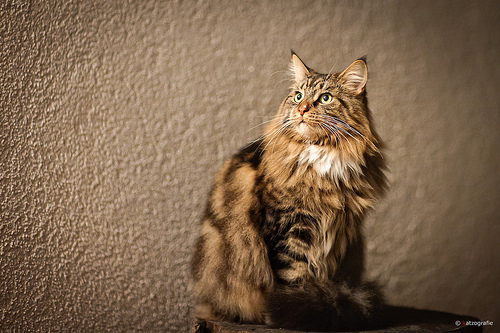

In [126]:
img = PILImage.create(get_image_files(path)[250])
img

In [127]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [128]:
x.shape

torch.Size([1, 3, 512, 512])

✏️ 한 개 이미지를 선택하여 텐서화를 진행한 결과, 이전 0-255 사이의 값을 가지던 픽셀들이 -3-3 사이의 값을 가지게 되었다. 이에 따라 이미지의 대비도가 높아져 향후 이미지 시각화 시 원본 이미지에 가까운 색을 띌 수 있게 선형변환을 진행할 예정이다.

In [129]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [130]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [131]:
net=torch.nn.Sequential(net1,net2)

✏️ CNN 후 CAM을 진행할 수 있도록 network의 형태를 일부 수정했다. 수정한 net2와 net1을 통합해 net을 생성하였으며 해당 network로 학습을 진행하고자 한다.

In [132]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [133]:
lrnr2.fine_tune(5) 

epoch,train_loss,valid_loss,accuracy,time
0,0.236000,0.595369,0.679973,00:40


epoch,train_loss,valid_loss,accuracy,time
0,0.140078,0.288207,0.902571,00:40
1,0.139799,0.164789,0.935047,00:40
2,0.094129,0.083530,0.966170,00:40
3,0.055424,0.053431,0.985115,00:40
4,0.031214,0.047379,0.984438,00:40


✏️ 우리는 첫번째 CAM이 발견한 특징(현재 예제에서는 고양이로 판별되는데 가장 크게 기여한 부분)을 제거한 후 CAM을 재실행하여 첫번째 시도에서 놓친(비교적 약하다고 판별된) 특징을 확인하는 과정을 반복적으로 수행할 것이기 때문에 특징의 면적이 좁을수록 이후 판별되는 특징과 구별이 수월하다. 따라서 epoch 수를 25회로 일반적인 학습의 경우보다 많게 진행하여 과적합을 유도하였다.

✏️✏️ 과적합을 위해 25회 학습을 진행하였으나, 고양이 이미지에서 처음에 얼굴을 판별해 낸 이후 얼굴을 제외한 모든 부분이 고양이로 판별된 이유로 (동일한 가중치를 가지고)확인되어서 epoch수를 늘려 보았다. (총 epoch=40) 40으로 늘렸더니 너무 이동이 느리다..

In [134]:
dls.vocab

['cat', 'dog']

In [135]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

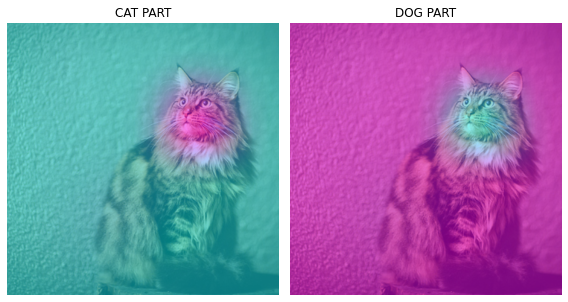

In [136]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

✏️ 원본 이미지 shape : $3X512X512$ $\to$ CNN $\to$ CAM 이미지 : $2X16X16$

In [137]:
test=camimg[0]-torch.min(camimg[0])

✏️ CAM img를 가중치로 보다 쉽게 사용할 수 있도록(?. 맞나?) 0~1 범위로 만들어주기 위해 각 픽셀 값에서 최소 픽셀값을 빼주었다.

In [138]:
A1=torch.exp(-0.03*test) 

✏️ k=(이름 넣어주기)값은 여러 값을 대입해 본 결과 가장 결과가 보기 좋은 값으로 설정하였다. k가 커질수록 MODE1에서 삭제되는 값의 범위가 넓어져 CAM img 결과와 같은 범위가 나오도록 적당한 조절이 필요하다.

In [139]:
A2=1-A1

In [140]:
#mode1_res*x
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
x1=x.squeeze().to('cpu')*Y1

In [141]:
#mode1*x
X12=np.array(A2.to("cpu").detach(),dtype=np.float32)
Y12=torch.Tensor(cv2.resize(X12,(512,512),interpolation=cv2.INTER_LINEAR))
x12=x.squeeze().to('cpu')*Y12

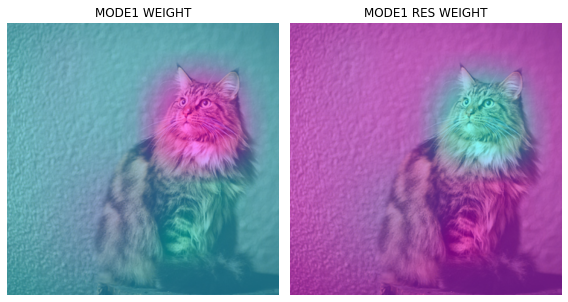

In [142]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE1 WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE1 RES WEIGHT")
#
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


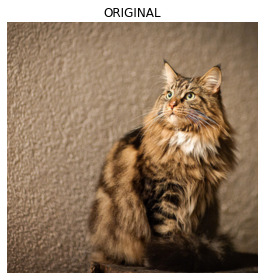

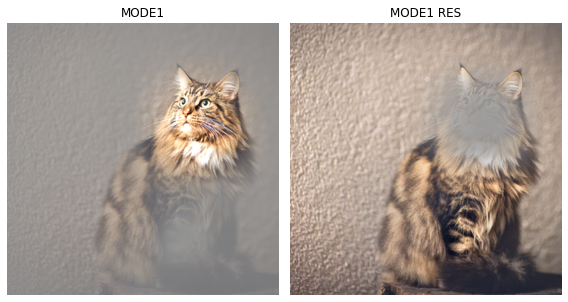

In [143]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
((x12-torch.min(x12))*0.3).squeeze().show(ax=ax1)  #MODE1
((x1-torch.min(x1))*0.3).squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [144]:
tt=(x1-torch.min(x1))*0.3

In [145]:
tt=tt.reshape(1,3,512,512)

In [146]:
x1=x1.reshape(1,3,512,512)

In [147]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [148]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(tt).squeeze())

- CAM

    - mode1_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


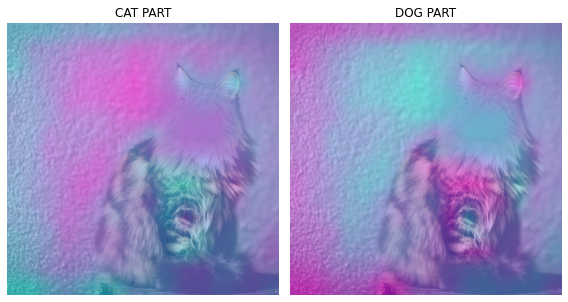

In [149]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
tt.squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
tt.squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째 CAM결과와 비교

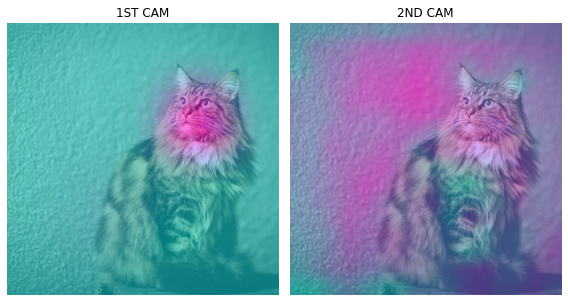

In [150]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [151]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(0.976113454903036, 0.023886545096963994)

---

#### 3rd CNN and CAM

- MODE 2 만들기

In [152]:
test1=camimg1[0]-torch.min(camimg1[0])

In [153]:
A3=torch.exp(-0.03*test1)  

In [154]:
A4=1-A3

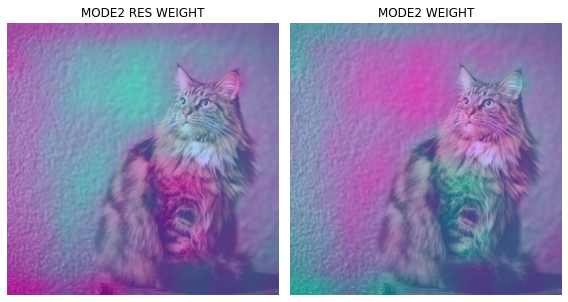

In [155]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("MODE2 RES WEIGHT")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("MODE2 WEIGHT")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [156]:
X2=np.array(A3.to("cpu").detach(),dtype=np.float32)
Y2=torch.Tensor(cv2.resize(X2,(512,512),interpolation=cv2.INTER_LINEAR))
x2=x.to("cpu").squeeze()*Y1*Y2

In [157]:
X22=np.array(A4.to("cpu").detach(),dtype=np.float32)
Y22=torch.Tensor(cv2.resize(X22,(512,512),interpolation=cv2.INTER_LINEAR))
x22=x.to("cpu").squeeze()*Y1*Y22

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


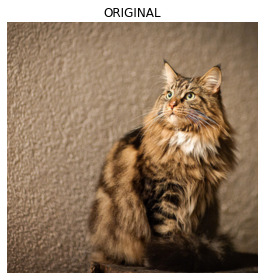

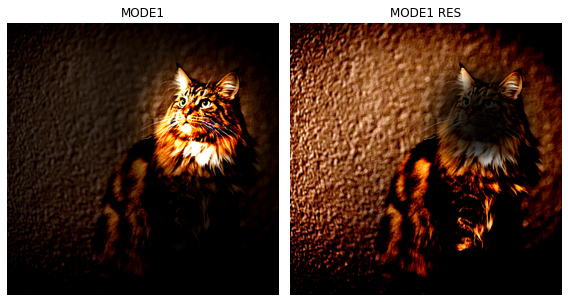

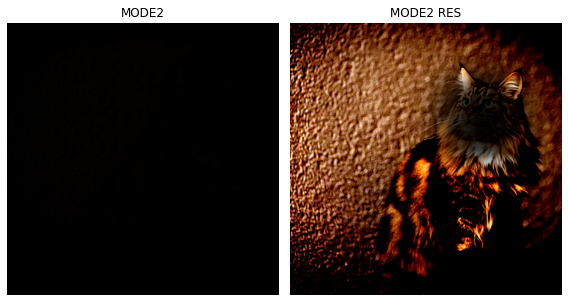

In [158]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("ORIGINAL")
fig.set_figwidth(4)            
fig.set_figheight(4)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x12.squeeze().show(ax=ax1)  #MODE1
x1.squeeze().show(ax=ax2)  #MODE1_res
ax1.set_title("MODE1")
ax2.set_title("MODE1 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()
#
fig, (ax1, ax2) = plt.subplots(1,2) 
x22.squeeze().show(ax=ax1)  #MODE2
x2.squeeze().show(ax=ax2)  #MODE2_res
ax1.set_title("MODE2")
ax2.set_title("MODE2 RES")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [159]:
x2=x2.reshape(1,3,512,512)

In [160]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [161]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x2).squeeze())

- CAM

    - mode2_res에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


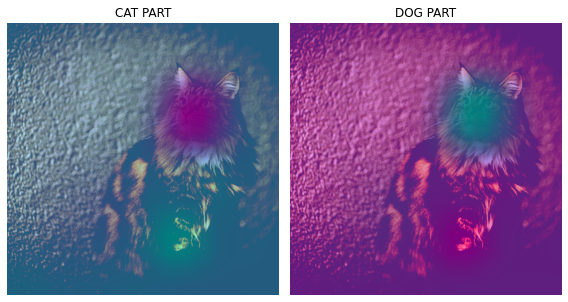

In [162]:
fig, (ax1, ax2) = plt.subplots(1,2) 
#
x2.squeeze().show(ax=ax1)
ax1.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("CAT PART")
#
x2.squeeze().show(ax=ax2)
ax2.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("DOG PART")
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째 CAM결과와 비교

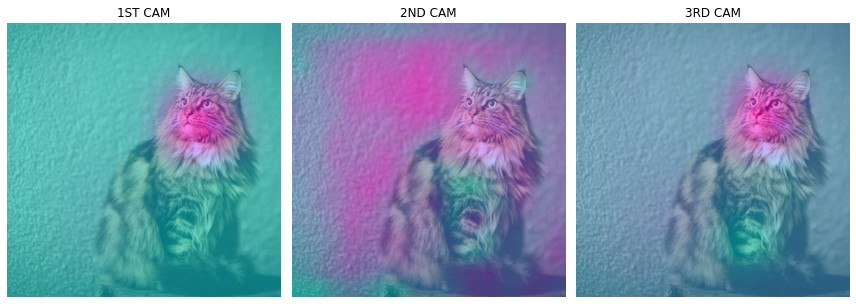

In [163]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax1.set_title("1ST CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("2ND CAM")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("3RD CAM")
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [324]:
a2=net(x2).tolist()[0][0]
b2=net(x2).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(0.27261557988582774, 0.7273844201141721)

---

## Proposed Method

In [51]:
x.shape

torch.Size([1, 3, 512, 512])